## Chapter 8

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Example 8.1
Empirical covariance matrix and spurious correlations for different ensemble sizes

In [3]:
Nz = 10
ensemble = [11,20,30,40,50,60,70,80,90,100,250,500,750,1000,2000]

J = len(ensemble)
# For each ensemble size, we want to repeat the experiment 1000 times
Aver = 1000

D = np.zeros((J))
C = np.zeros((J,Nz))

for j in range(J):
    M = ensemble[j]
    
    e = np.ones(M)
    
    for jj in range(Aver):
        # Ensemble of size M with N dimensions for each member
        X = np.random.randn(Nz,M)
        X -= X.mean(axis=1).reshape(-1,1)
        P = 1./(M-1) * np.dot(X,X.T)
        
        # Want to find determinant of P. SVD decomposition gives U, S, V. det(U) and det(V) = +/-1,
        # while det(S) = prod(S), then det(P) = prod(S)
        _,S,_ = np.linalg.svd(P)
        
        D[j] += np.prod(S)**(1./Nz)
        
        # equation 8.2
        eye = np.eye(P.shape[0], dtype=bool)
        P_offdiag = np.copy(P)
        P_offdiag[np.where(eye == True)] = 0.
        C[j,:] += 1./(Nz-1.) * np.abs(P_offdiag).sum(axis=0)
        
D /= Aver
C /= Aver
C = C.mean(axis=1)

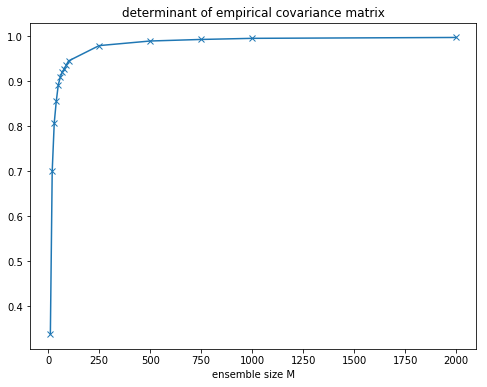

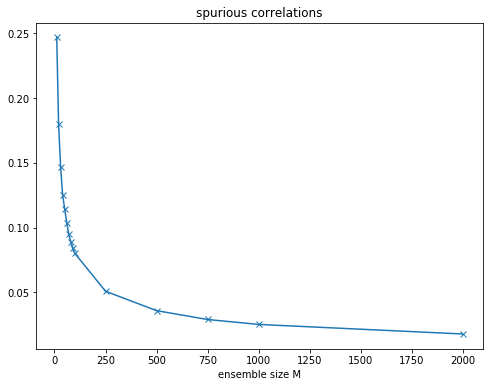

In [4]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(ensemble,D, '-x')
plt.xlabel("ensemble size M")
plt.title("determinant of empirical covariance matrix")
plt.show()

fig0b = plt.figure(figsize=(8,6))
plt.plot(ensemble,C, '-x')
plt.xlabel("ensemble size M")
plt.title("spurious correlations")
plt.show()

### Example 8.4 (Linear advection and method of characteristics)

In [5]:
# define time and step sizes
Dx = 0.01
Dt = 0.001

# define grid lengths
x = np.linspace(0.,1.,100)
t = np.linspace(0.,4.,4000)

# and the corresponding 2D grid
xx, tt = np.meshgrid(x,t)

# set up initial conditions for spatial grid
xk = np.zeros((t.shape[0],x.shape[0]))
xk[0,:] = xx[0,:]

# solve the constant characteristic solution
U = np.sin(2.*np.pi*xx)

# forward Euler for spatial grid
for step in range(t.shape[0] - 1):
    xk[step+1,:] = xk[step,:] + Dt * np.sin(2.*np.pi*xk[step,:]) * np.cos(np.pi*tt[step])

<IPython.core.display.Javascript object>


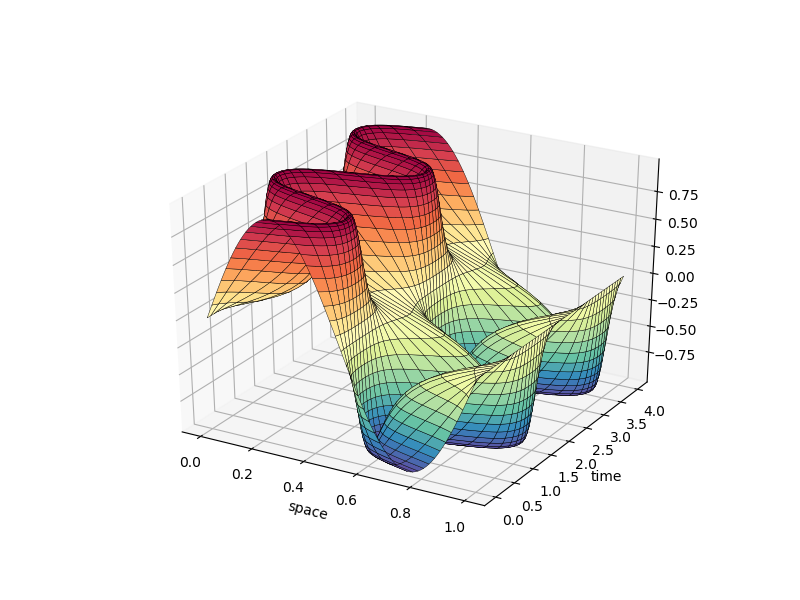

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig1 = plt.figure(figsize=(8,6))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xk,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

### Example 8.5 (Upwind scheme for linear advection)

In [7]:
Dt = 0.01
Dx = 0.01

res = 100
x = np.linspace(0,1,res)
t = np.linspace(0.01,4,res)

xx, tt = np.meshgrid(x,t)
U = np.empty_like(xx) * 0.

# initial condition
U[0,:] = np.sin(2.*np.pi*xx[0,:])

def func_a(x,t):
    return (np.sin(2. * np.pi * x) * np.cos(np.pi * t))

Uleft = np.zeros((x.shape[0]))

for step in range(1,t.shape[0]):
    Uleft[1:] = U[step-1,:-1]
    Uleft[0] = U[step-1,-1]
    U[step,:] = U[step-1,:] - func_a(xx[step-1,:],tt[step-1,:]) * Dt/Dx *  (U[step-1,:] - Uleft)
    RHS = func_a(xx[step-1,:],tt[step-1,:]) * Dt/Dx *  (U[step-1,:] - Uleft)

<IPython.core.display.Javascript object>


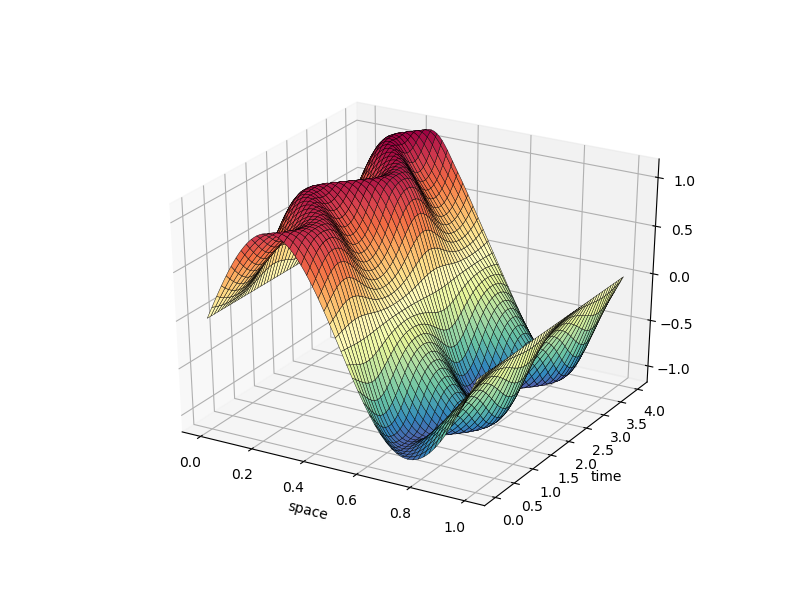

In [8]:
fig2 = plt.figure(figsize=(8,6))
ax = fig2.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xx,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

### Example 8.6 (leading singular value of a 'stochastic' Burgers' equation)

In [178]:
L = 1.
J = 100
mu = 0.0005

# set step-sizes
dx = 0.01
dt = 0.001

STEPS = 80
INNER = 125

ensemble = [5,10,500,1000]
K = len(ensemble)

xgrid = np.arange(1,J+1)*dx
time = np.zeros((STEPS))
SV = np.zeros((STEPS,K))

for k in range(K):
    M = ensemble[k]
    u = np.zeros((J,M))
    
    Nf = 20
    xi = np.zeros((Nf,M))
    xs = xgrid.reshape((-1,1)) * np.arange(1,Nf+1).reshape((1,-1))
    F = np.sin(2. * np.pi / L * xs)
    D = np.diag(np.arange(1,Nf+1)**2)
    
    e = np.ones((M,1))
    
    for n in range(STEPS):
        for nn in range(INNER):
            xi = xi - dt*np.dot(D,xi) + np.sqrt(dt)*np.random.randn(Nf,M)
            u = u - dt*(np.roll(u,-1,axis=0)**2 - np.roll(u,+1,axis=0)**2) / (4.*dx) + mu*dt*(np.roll(u,-1,axis=0) - 2.*u + np.roll(u,+1,axis=0)) / dx**2 \
                + dt * np.dot(F,xi)
            
        umean = np.dot(u,e)/M
        U = u - umean*e.T
        P = 1./(M-1.) * np.dot(U,U.T)
        SV[n,k] = np.linalg.svd(P,compute_uv=False).max()
        time[n] = INNER*dt*n

<IPython.core.display.Javascript object>


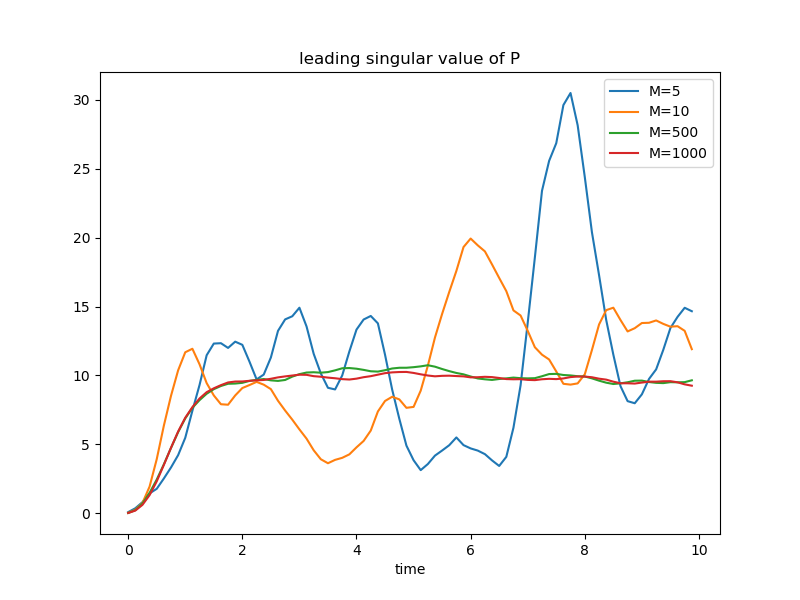

In [179]:
fig3a = plt.figure(figsize=(8,6))
plt.plot(time,SV[:,0])
plt.plot(time,SV[:,1])
plt.plot(time,SV[:,2])
plt.plot(time,SV[:,3])
plt.xlabel("time")
plt.title("leading singular value of P")
plt.legend(["M=5","M=10","M=500","M=1000"])
plt.show()

In [218]:
L = 1.
J = 100
STEPS = 300
INNER = 15

U = np.zeros((J,STEPS+1))
xi0 = np.copy(xi[:,0])
xi0 = xi0.reshape(-1,1)
u0 = np.copy(u[:,0]).reshape(-1,1)
U[:,0] = u0.reshape(-1)

T = 10.
time = np.arange(T,T+STEPS*INNER*dt+dt,dt*INNER)

tt,xx = np.meshgrid(time,xgrid)

for n in range(STEPS):
    for _ in range(INNER):
        xi0 = xi0 - dt*np.dot(D,xi0) + np.sqrt(dt)*np.random.randn(Nf,1)
        u0 = u0 - dt*(np.roll(u0,-1,axis=0)**2 - np.roll(u0,+1,axis=0)**2) / (4.*dx) + mu*dt*(np.roll(u0,-1,axis=0) - 2.*u0 + np.roll(u0,+1,axis=0)) / dx**2 \
                + dt * np.dot(F,xi0)
        
    U[:,n+1] = u0.reshape(-1)

<IPython.core.display.Javascript object>


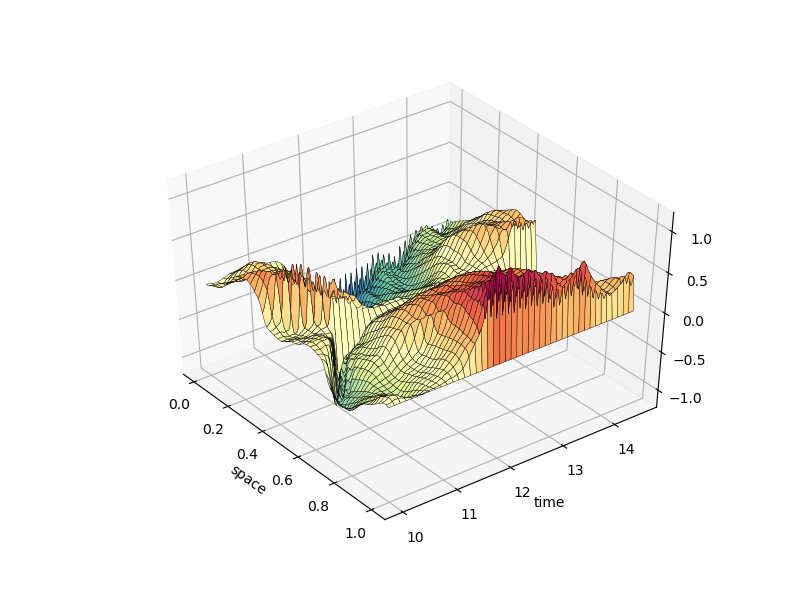

In [219]:
fig3b = plt.figure(figsize=(8,6))
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
ax = fig3b.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xx,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()